## To-Do : Problème avec le changement de format du memmap de movie.data en float16. Idéalement faudrait trouver un moyen que ça chie pas. Peut-être call un object égal à la matrice self.data[0][0][0] ? 

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 12 13:38:43 2023

@author: je_gu
"""
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import sys
import imageio.v2 as imageio
#import imageio
module_path = r'/Users/vincentchouinard/Documents/GitHub/Widefield-Imaging-analysis'
sys.path.insert(1,module_path)
from motion_correction_caiman import *
from WFmovie import WFmovie
from WFmovie import create_channel
from PyQt5.QtWidgets import QFileDialog, QApplication
import tifffile

2023-02-03 14:42:09.198554: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#%% function to searchpath(). Tried with tkinter at first, but not compatible with MacOS internal DUI

def search_path():
    app = QApplication([])
    folder_selected = QFileDialog.getExistingDirectory()
    print ("You chose: %s" % folder_selected)
    return folder_selected

print("Where is your data folder?")
folderpath= search_path()

Where is your data folder?
You chose: /Users/vincentchouinard/Documents/Maitrise/Data/CVR_31jan_M28


In [ ]:
def tif_to_numpy(tif, dtype=None):
    imageio_array = imageio.imread(tif, dtype)
    numpy_array = np.array(imageio_array, dtype)
    return numpy_array

In [3]:
#%% Setup

data_path = Path(folderpath)
strpath = str(data_path)
#for i in np.arange(0,len(strpath)):
#    if strpath[i] == os.sep:
#        last_backslash_ind = i
#file = strpath[last_backslash_ind+1:-1] #Semble être inutile, et il manque la dernière lettre du file
channels_exist = True
channels = ['green'] #blue,green,red,ir
binning = False
normalize = False
gaussian_filter = False
gaussian_std = 1
temp_med_filter = False
temp_med_width = 3
substract_background = False
if substract_background is True:
    background_path = r'E:\Data Jeremie\Calcium imaging tests\M26\background'
#%% Create channels
if channels_exist is False:
    for channel in channels:
        create_channel(data_path,channel,r'experiment-metadata.json',binning)
#%% Create movies
movies = []
for channel in channels:
    movie = WFmovie(data_path,channel)
    if substract_background is True:
        background = np.mean(np.load(background_path+r'\data\0.npy'),axis=0)
        if binning is True:
            image = Image.fromarray(background)
            image = image.convert('F') #F = 32-bit floating point
            background = np.array(image.resize((movie.ncols,movie.nrows), resample=Image.Resampling.BILINEAR))
        movie.data = movie.data-background
    if normalize is True:
        movie.normalize_by_mean()
    if gaussian_filter is True:
        movie.gaussian_filt(gaussian_std)
    if temp_med_filter is True:
        movie.med_temp_filt(temp_med_width)
    movies.append(movie)

In [5]:
ON EST ICI DANS LE FOND. Y FAUT GÉRER LE NUMPY.MEMMAP

SyntaxError: invalid syntax (4057438363.py, line 1)

/opt/anaconda3/envs/wia/lib/python3.9/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.


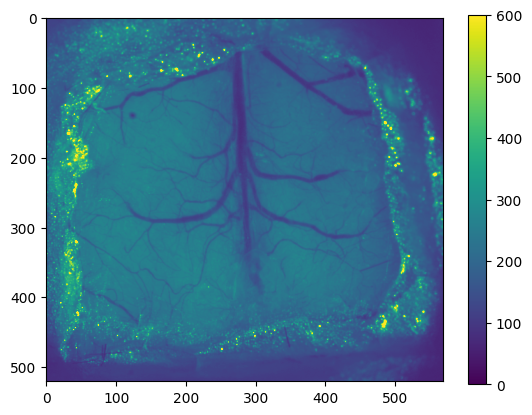

In [16]:
#%% Show movies

movie = movies[0]
#mask = movie.create_mask()
#movie.apply_mask(mask)
#moviearray = movie.convert_to_2d_matrix()

fig, ax = plt.subplots()
vmin = 0
vmax = 600
framerate=1/movie.freq #le arg "interval" est en ms
def animate(i):
    ax.clear()
    plt.axis('off')
    ax.imshow(movie.data[i,:,:],vmin=vmin,vmax=vmax)
im = ax.imshow(movie.data[0],vmin=vmin,vmax=vmax)
cb = plt.colorbar(im)
anim = animation.FuncAnimation(fig, animate,frames=movie.nframes,interval=framerate)
plt.show()

In [38]:
#%% Creates a folder named "Correction"

Correction_folder_name = 'Correction'
newfolderpath = "".join([folderpath,  '/', Correction_folder_name])
if not os.path.exists(newfolderpath):
    os.makedirs(newfolderpath)
    
path = os.path.normpath(newfolderpath)
print('path: ' + path)
pathlist = path.split(os.sep)
print(pathlist)
filename = "".join([pathlist[-1], "_", channel, '_movie', '.tif'])
print("filename: " + filename)
newfilepath = newfolderpath / filename
print("newfilepath: " + newfilepath)

/Users/vincentchouinard/Documents/Maitrise/Data/CVR_31jan_M28/Correction//Correction
path: /Users/vincentchouinard/Documents/Maitrise/Data/CVR_31jan_M28/Correction/Correction
['', 'Users', 'vincentchouinard', 'Documents', 'Maitrise', 'Data', 'CVR_31jan_M28', 'Correction', 'Correction']
filename: Correction_green_movie.tif


TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [ ]:
movie.convert_to_tif(newfilepath, convert16=True)

In [25]:
#%% Saving movie in file

path = os.path.normpath(folderpath)
pathlist = path.split(os.sep)
filename = "".join([pathlist[-1], "_", channel, '_movie', '.tif'])
filepath = data_path / filename
movie.convert_to_tif(filepath, convert16=True)

In [26]:
#%% CaImAn
correction_folder = "Correction"
parameters = get_wf_mc_params()
folderpath = folderpath + '/' + correction_folder + '/'

In [13]:
correct_motion_directory(folderpath, parameters, keywords=['.tif'])

Searching directory for uncorrected data in /Users/vincentchouinard/Documents/Maitrise/Data/CVR_11jan/Correction/...
Calcium imaging data to correct: ['CVR_11jan_green_movie.tif']
Beginning motion correction...
Correcting CVR_11jan_green_movie.tif...


2023-02-03 10:54:25.123828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 10:54:25.123805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 10:54:25.123828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Decode mmap filename /Users/vincentchouinard/Documents/Maitrise/Data/CVR_11jan/Correction/CVR_11jan_green_movie_els__d1_457_d2_532_d3_1_order_F_frames_2400.mmap


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Done!


In [64]:
def tif_to_numpy(tif, dtype=None):
    imageio_array = imageio.imread(tif, dtype)
    numpy_array = np.array(imageio_array, dtype)
    

In [33]:
tif_to_numpy("".join([folderpath, filename]))

FileNotFoundError: No such file: '/Users/vincentchouinard/Documents/Maitrise/Data/CVR_31jan_M28/Correction/CVR_31jan_M28_green_movie.tif'

## Files and folders, paths and names. 

### Creates a "Correction" folder

In [52]:
Correction_folder_name = 'Correction'
newfolderpath = "".join([folderpath,  '/', Correction_folder_name])
if not os.path.exists(newfolderpath):
    os.makedirs(newfolderpath)

### Creates a .tif from self.data (movie) object of WFMovie class. Puts the .tif file in the "Correction" folder

In [59]:
#%% Saving movie in file

path = os.path.normpath(folderpath)
pathlist = path.split(os.sep)
filename = "".join([pathlist[-1], "_", channel, '_movie', '.tif'])
filepath = data_path / newfolderpath / filename
movie.convert_to_tif(filepath, convert16=True)

/Users/vincentchouinard/Documents/Maitrise/Data/CVR_31jan_M28
['', 'Users', 'vincentchouinard', 'Documents', 'Maitrise', 'Data', 'CVR_31jan_M28']
CVR_31jan_M28_green_movie.tif
/Users/vincentchouinard/Documents/Maitrise/Data/CVR_31jan_M28/Correction/CVR_31jan_M28_green_movie.tif


## CaImAn motion correction on .tif file

In [63]:
parameters = get_wf_mc_params()
CaImAn_folder_path = newfolderpath + '/'
correct_motion_directory(CaImAn_folder_path, parameters, keywords=['.tif'])

Searching directory for uncorrected data in /Users/vincentchouinard/Documents/Maitrise/Data/CVR_31jan_M28/Correction/...
Calcium imaging data to correct: ['CVR_31jan_M28_green_movie.tif']
Beginning motion correction...
Correcting CVR_31jan_M28_green_movie.tif...


2023-02-03 13:28:52.477597: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 13:28:52.478106: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 13:28:52.478121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Decode mmap filename /Users/vincentchouinard/Documents/Maitrise/Data/CVR_31jan_M28/Correction/CVR_31jan_M28_green_movie_els__d1_521_d2_569_d3_1_order_F_frames_4000.mmap


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.27s/it]


Done!


## Return to .npy for normalization and data measures

In [80]:
npyfilename = Path("".join(['corrected_', pathlist[-1], "_", channel, '_movie', '.npy']))
newnpypath = newfolderpath / npyfilename
corrected_tif_filename = "".join(['corrected_', filename])
corrected_tif_path = data_path / newfolderpath / corrected_tif_filename
imageio_array = imageio.imread(corrected_tif_path)
nparray = np.array(imageio_array, dtype=np.float32)
np.save(newnpypath, nparray)

In [81]:
corrected_movie = np.load(newnpypath)

In [1]:
#print(movie.data)
print(type(movie.data[0][0][0]))
print(type(corrected_movie[0][0][0]))
print(movie.data[0][0][0])
print(corrected_movie[0][0][0])

NameError: name 'movie' is not defined